In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    auc,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
import matplotlib.pyplot as plt
from joblib import dump
import os
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)
results = {}

In [3]:
# Load the data
df = pd.read_csv(
    "/Users/Sam/Documents/Duke/Spring 2024/IDS 705/Final Project/the_real_final_df.csv"
)
df = df.drop(
    columns=[
        "participantid",
        "gameid",
        "champion",
        "playerid",
        "side",
        "pick2",
        "pick3",
        "pick4",
        "pick5",
        "opp_pick1",
        "opp_pick2",
        "opp_pick3",
        "opp_pick4",
        "opp_pick5",
    ]
)

In [4]:
# Split the data into X and y
X = df.drop(columns=["result"])
y = df["result"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
# Create a pipeline that standardizes the data, applies PCA and then fits a logistic regression model
pipeline = Pipeline(
    [("scaler", StandardScaler()), ("pca", PCA()), ("logistic", LogisticRegression())]
)

# Parameters for GridSearchCV
param_grid = {
    "pca__n_components": [0.8, 0.9, 0.95],
    "logistic__C": np.logspace(-4, 4, 4),
}

In [6]:
# Create GridSearchCV to find the best model
search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=5, scoring="roc_auc")
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.655):
{'logistic__C': 10000.0, 'pca__n_components': 0.95}


In [7]:
# Save the best model
dump(search.best_estimator_, "log_reg_best_model.joblib")

['log_reg_best_model.joblib']

In [8]:
# Make predictions on the test set
y_pred = search.best_estimator_.predict(X_test)

# Predict probabilities for the test set
probabilities = search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, probabilities)
pr_auc = average_precision_score(y_test, probabilities)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision_score = precision_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print("Accuracy (Logistic Regression): ", round(accuracy, 4))
print("Precision (Logistic Regression): ", round(precision_score, 4))
print("Recall (Logistic Regression): ", round(recall_score, 4))
print("F1 Score (Logistic Regression): ", round(f1, 4))
print("AUC ROC (Logistic Regression): ", round(roc_auc, 4))
print("AUC PR (Logistic Regression): ", round(pr_auc, 4))

Accuracy (Logistic Regression):  0.6107
Precision (Logistic Regression):  0.6138
Recall (Logistic Regression):  0.6662
F1 Score (Logistic Regression):  0.6389
AUC ROC (Logistic Regression):  0.6495
AUC PR (Logistic Regression):  0.6452


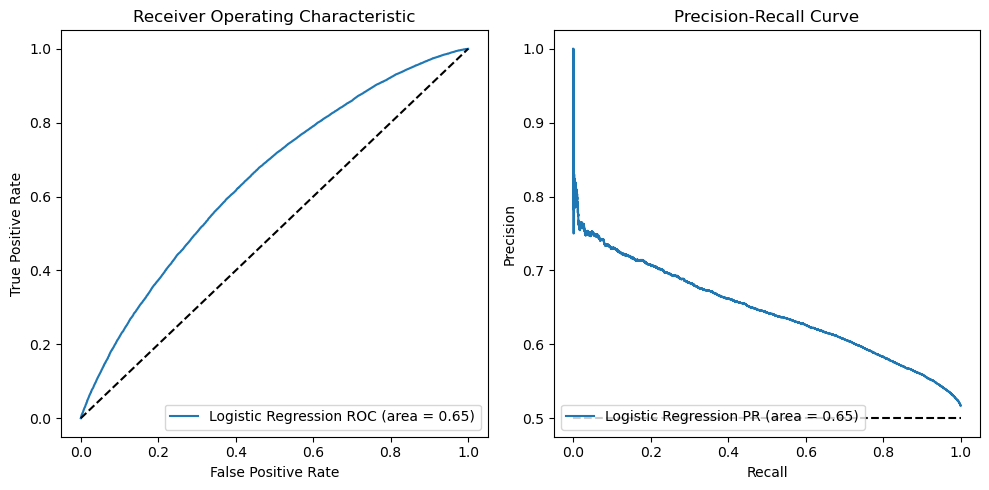

In [9]:
# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"Logistic Regression ROC (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"Logistic Regression PR (area = {pr_auc:.2f})")
plt.plot([0, 1], [0.5, 0.5], "k--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

In [11]:
list1, list2, _ = roc_curve(y_test, probabilities)
pd.DataFrame({"fpr": list1, "tpr": list2}).to_csv("log_reg_roc_curve.csv", index=True)